# PROYECTO - CARS - DSA

In [2]:
# Importación librerías
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import pickle

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import mlflow
# Global settings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 40

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('datos/dataTrain_carListings.csv')
dataTesting = pd.read_csv('datos/dataTest_carListings.csv', index_col=0)
data = dataTraining.drop(columns=['Predictions'])
test = dataTesting

## Análisis Exploratorio de Datos

In [4]:
# Visualización datos de entrenamiento
data.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
categorical_cols=data.select_dtypes(include=['object']).columns
categorical_cols

Index(['State', 'Make', 'Model'], dtype='object')

In [6]:
numerical_cols=data.select_dtypes(exclude=['object']).columns
numerical_cols

Index(['Price', 'Year', 'Mileage'], dtype='object')

In [7]:
data.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [8]:
df_price = data.groupby(["Make", "Model"])["Price"].mean()

# Ordena descendente por precio
top_3_Alto = df_price.sort_values(ascending=False).head(3)
top_3_Bajo = df_price.sort_values(ascending=True).head(3)

top_3_Alto = top_3_Alto.reset_index().rename(columns={"Price": "Average Price"})
top_3_Bajo = top_3_Bajo.reset_index().rename(columns={"Price": "Average Price"})

top_3_Alto["Average Price"]=round(top_3_Alto["Average Price"])
top_3_Bajo["Average Price"]=round(top_3_Bajo["Average Price"])

# resultados
print("Top Vehículos con precio más alto por marca y modelo")
display(top_3_Alto)
print("Top Vehículos con precio más bajo por marca y modelo")
display(top_3_Bajo)

Top Vehículos con precio más alto por marca y modelo


,Make,Model,Average Price
0,Bentley,Continental,57256.0
1,Tesla,Model,55649.0
2,Chevrolet,CorvetteConvertible,54277.0


Top Vehículos con precio más bajo por marca y modelo


,Make,Model,Average Price
0,Chrysler,PT,6271.0
1,Chevrolet,Cobalt2dr,6645.0
2,Ford,Escape4dr,6664.0


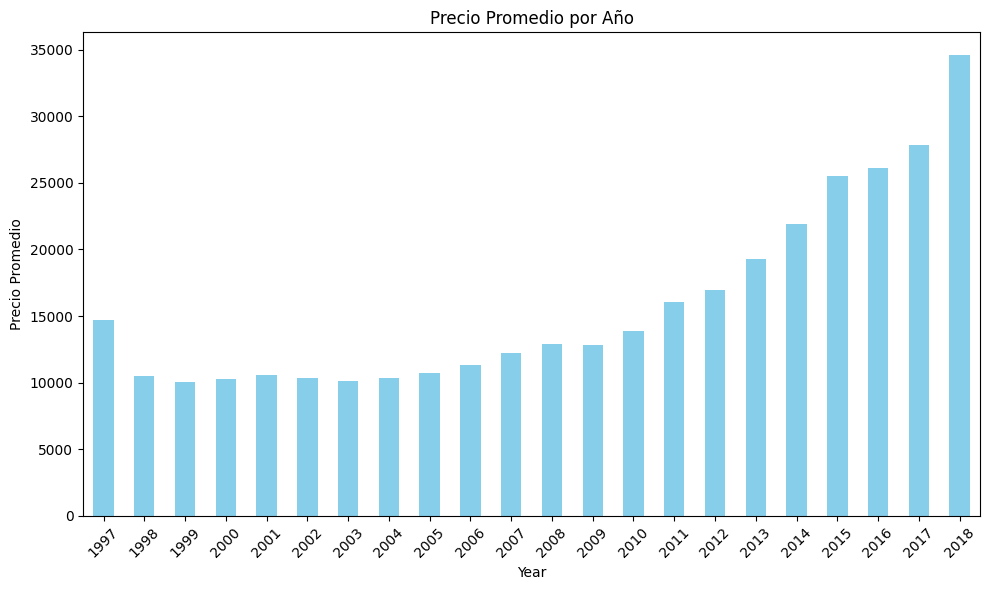

In [9]:

# Agrupa por "Model" y calcula el precio promedio
df_Y = data.groupby("Year")["Price"].mean()

# Crea un gráfico
plt.figure(figsize=(10, 6))
df_Y.plot(kind="bar", color='skyblue')
plt.title("Precio Promedio por Año")
plt.xlabel("Year")
plt.ylabel("Precio Promedio")
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()


In [10]:
df=pd.DataFrame(data['Make'].value_counts()).reset_index().rename(columns={'index':'make'})
df

,Make,count
0,Ford,62899
1,Chevrolet,58383
2,Toyota,45941
3,Honda,33191
4,Jeep,24369
5,GMC,20834
6,Kia,16352
7,Dodge,16159
8,Hyundai,15057
9,Lexus,13664


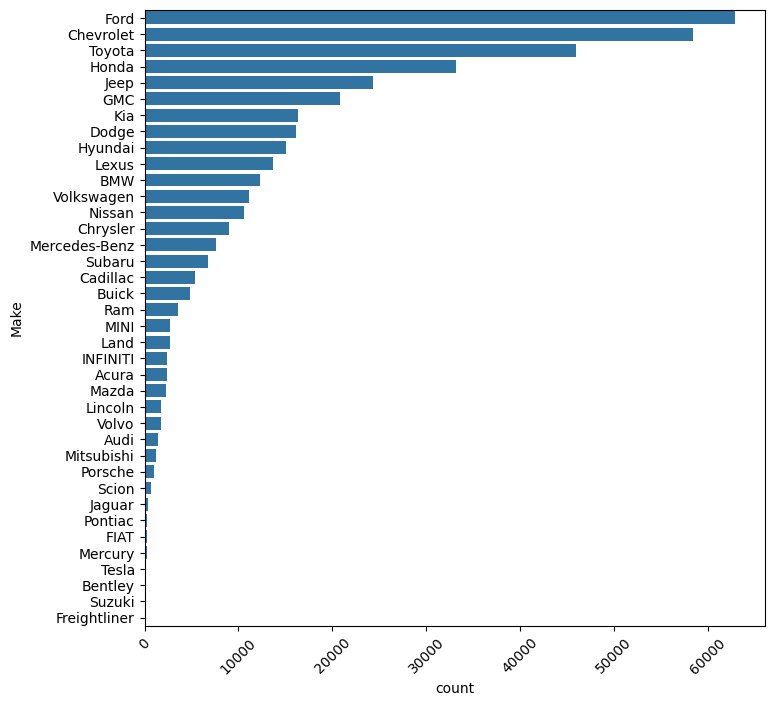

In [11]:
# Cantidad de carros por marca
plt.figure(figsize=(8,8))
plot = sns.barplot(y='Make',x='count',data=df)
plot=plt.setp(plot.get_xticklabels(), rotation=45)

In [12]:
df2=pd.DataFrame(data['State'].value_counts()).reset_index().rename(columns={'index':'state'})

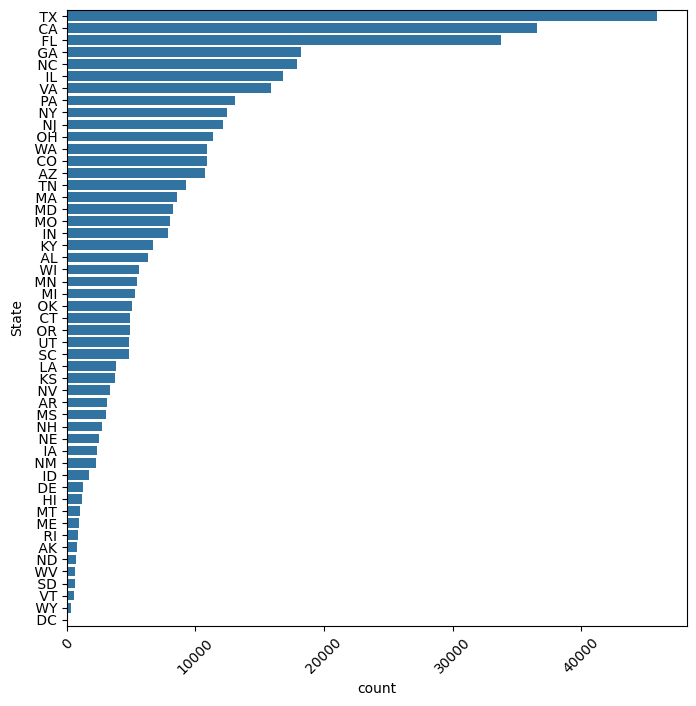

In [13]:
# Cantidad de vehículos por state
plt.figure(figsize=(8,8))
plot = sns.barplot(y='State',x='count',data=df2)
plot=plt.setp(plot.get_xticklabels(), rotation=45)

<Axes: xlabel='Price', ylabel='Density'>

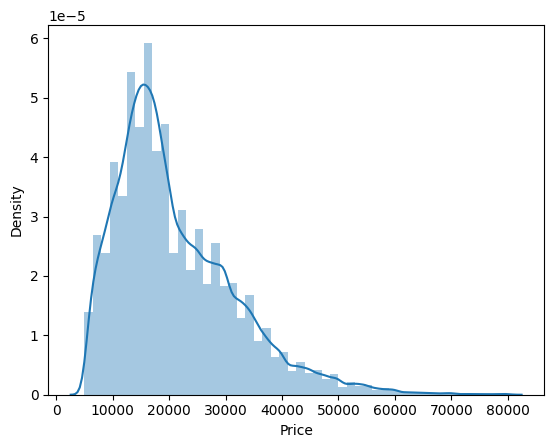

In [14]:
# Distribución del Precio de los carros
sns.distplot(data['Price'],kde=True)

In [15]:
# Codificación de las variables categoricas
cat = ['State','Make','Model']
dic = {'State':{},'Make':{},'Model':{}}

for i in cat:
    idx, codex = pd.factorize(data[i])
    data[i] = idx
    # Diccionario de referencia
    dic[i].update({code: i for i, code in enumerate(codex)})
    # Codificación de variables en testing con base en el diccionario
    test[i] = test[i].apply(lambda code: dic[i][code])

In [16]:
#Exportar dicionario para usarlo en la API
import json

# Guardar el diccionario en formato JSON
with open("deployment/cod_categoricas.json", 'w') as archivo:
    json.dump(dic, archivo)

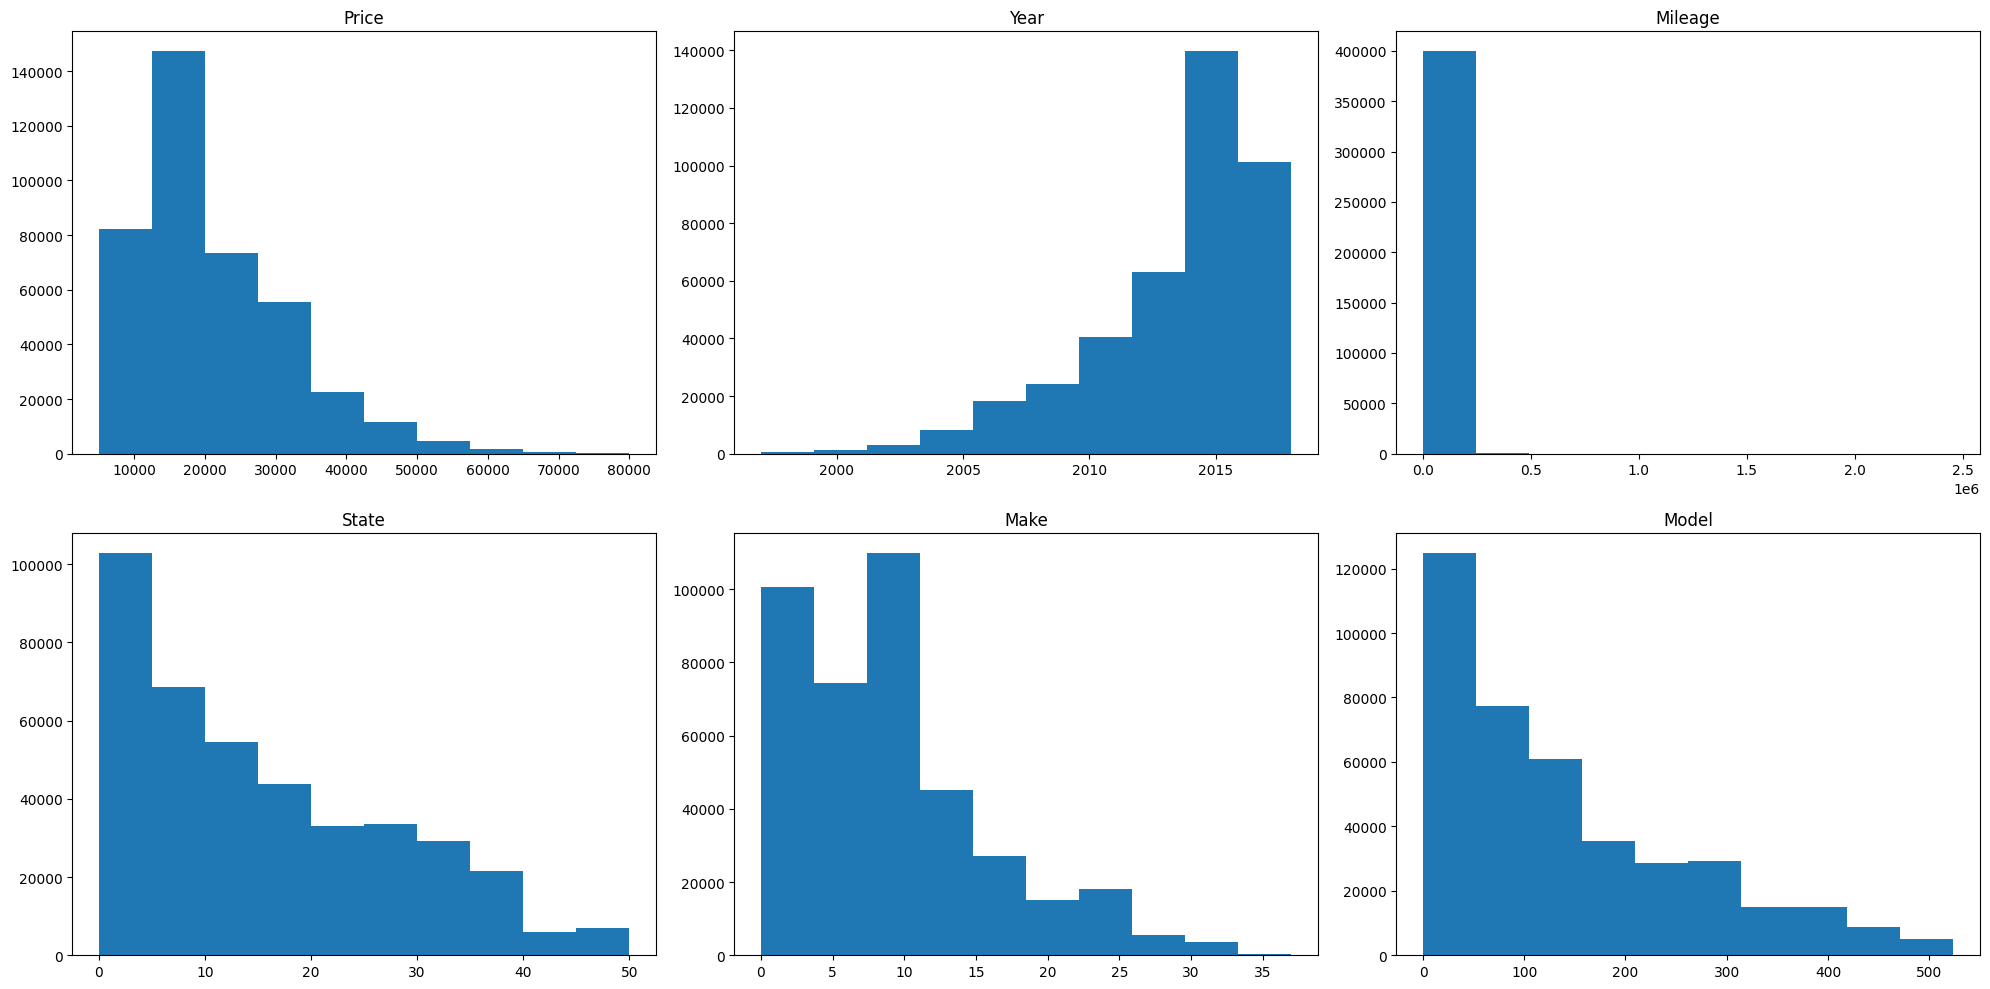

In [17]:
# df = data[['Price','Mileage','Year']]
df = data
filas = math.ceil(len(df.columns) / 3)
fig, a = plt.subplots(filas,3,figsize=(20, 10))

a = a.ravel()
titles = df.columns

for i, ax in enumerate(a):
    
    if i < len(df.columns):
        ax.hist(df.iloc[:,i])
        ax.set_title(titles[i])
plt.tight_layout()

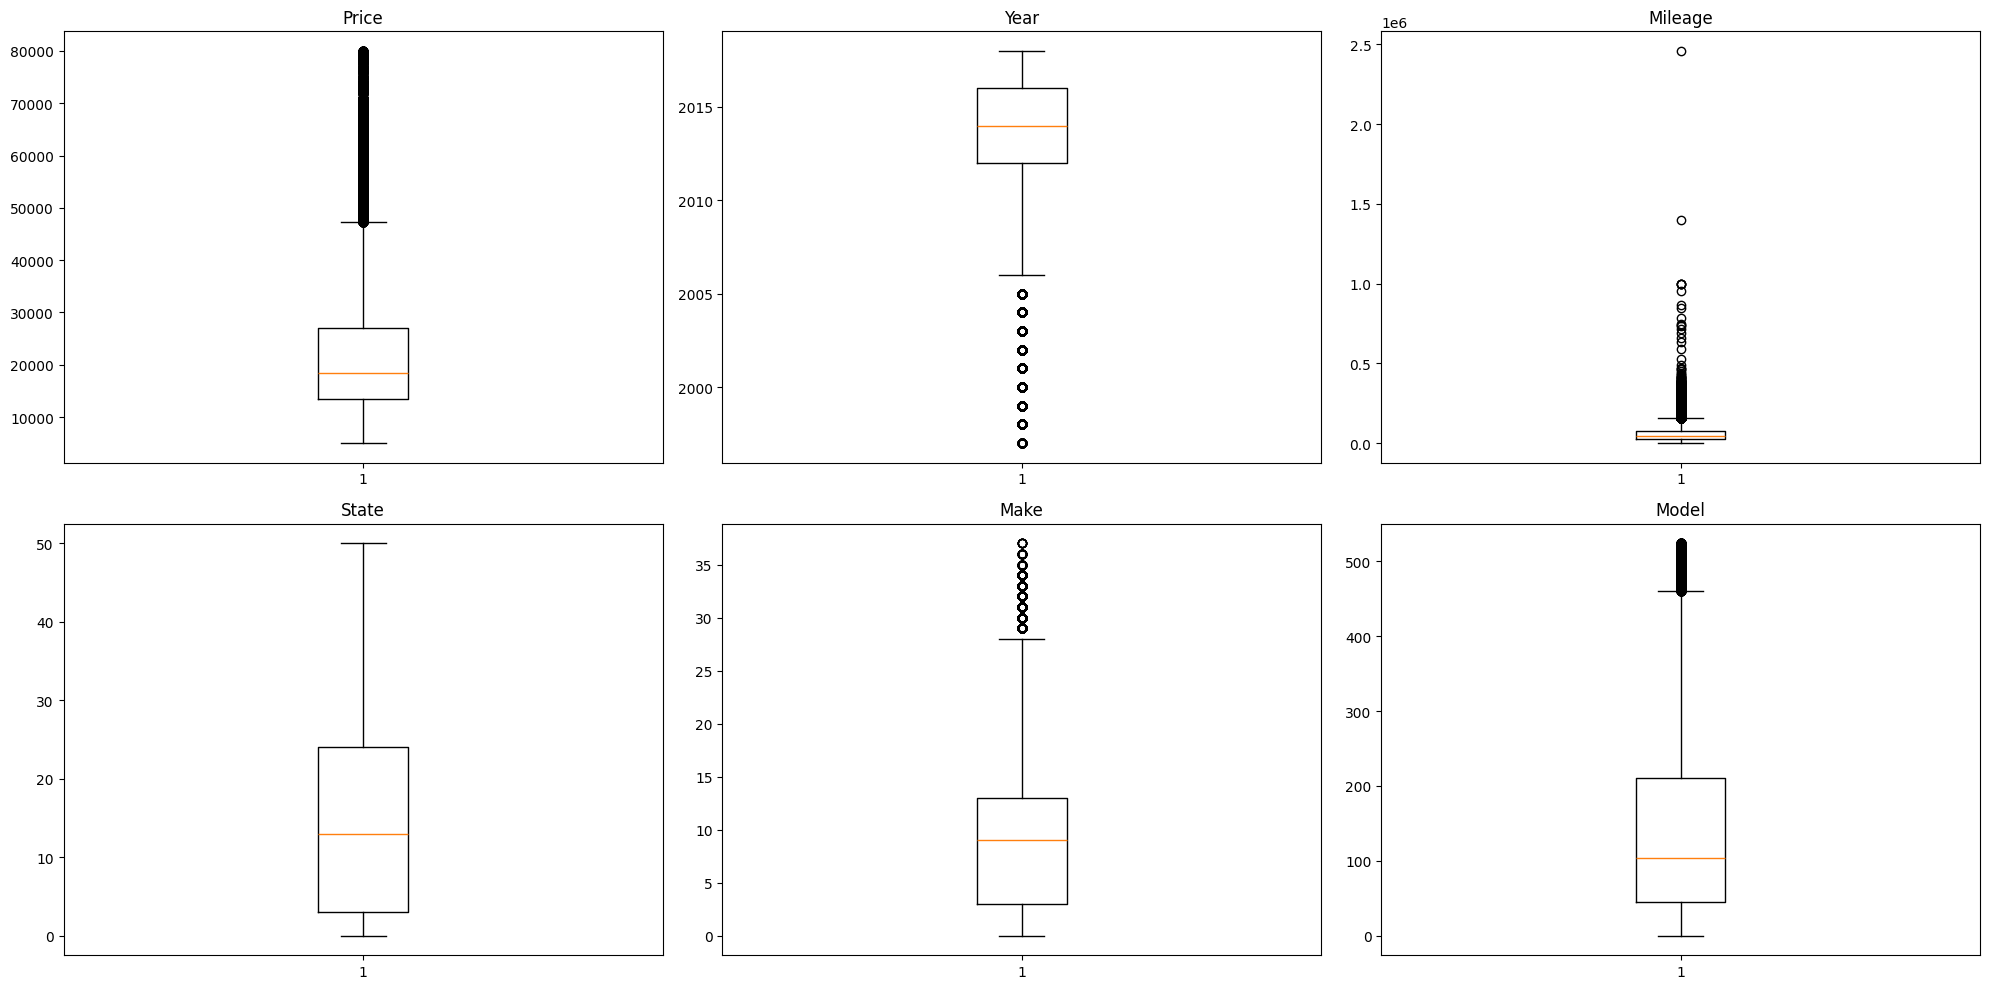

In [18]:
# df = data[['Price','Mileage','Year']]
df = data
filas = math.ceil(len(df.columns) / 3)
fig, a = plt.subplots(filas,3,figsize=(20, 10))

a = a.ravel()
titles = df.columns

for i, ax in enumerate(a):
    
    if i < len(df.columns):
        ax.boxplot(df.iloc[:,i])
        ax.set_title(titles[i])
plt.tight_layout()

In [19]:

# Control de Outliers
Q1 = data['Price'].quantile(0.25)
print('Primer Cuartil:', Q1)

Q3 = data['Price'].quantile(0.75)
print('Tercer Cuartil:', Q3)

IQR = Q3 - Q1
print('Rango Intercuartil:', IQR)

Mediana = data['Price'].median()
print('Mediana:', Mediana)

Valor_Minimo = data['Price'].min()
print('Valor Mínimo:', Valor_Minimo)

Valor_Maximo = data['Price'].max()
print('Valor Máximo:', Valor_Maximo)

BI_Calculado = (Q1 - 1.5 * IQR)
print('BI_Calculado: \n', BI_Calculado)

BS_Calculado = (Q3 + 1.5 * IQR)
print('BS_Calculado: \n', BS_Calculado)


Primer Cuartil: 13499.0
Tercer Cuartil: 26999.0
Rango Intercuartil: 13500.0
Mediana: 18450.0
Valor Mínimo: 5001
Valor Máximo: 79999
BI_Calculado: 
 -6751.0
BS_Calculado: 
 47249.0


In [20]:
ubicacion_outliers = (data['Price'] < BI_Calculado) | (data['Price'] > BS_Calculado)

In [21]:
outliers = data[ubicacion_outliers]
print('\n Lista de Outliers \n', outliers)

ubicacion_sin_out = (data['Price'] >= BI_Calculado) & (data['Price'] <= BS_Calculado)
data = data[ubicacion_sin_out]



 Lista de Outliers 
         Price  Year  Mileage  State  Make  Model
90      61700  2017      355      5     1     68
122     49977  2015    25740      7     1     86
128     47550  2011    47383     22    22     91
168     51400  2015    44905      2    10    105
187     73216  2016     4912      2     1    117
...       ...   ...      ...    ...   ...    ...
399900  59980  2017    10989      2     1     45
399931  67365  2017     4519      0     9    144
399956  63900  2016    21501     32    22     91
399957  52998  2017     4694     25     2    230
399992  50990  2017    23896      2    27    162

[10880 rows x 6 columns]


<Axes: >

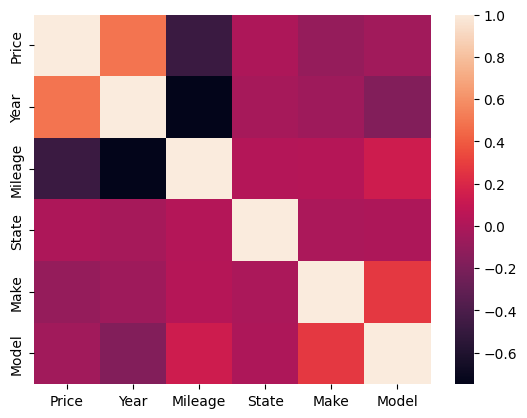

In [22]:
sns.heatmap(data.corr())

In [23]:
# Selección de variables numéricas (X)

X = data.drop(['Price'], axis=1)

X['YxM'] = X['Year'] * X['Mileage']
test['YxM'] = test['Year'] * test['Mileage']

y = data['Price']

In [24]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)

In [25]:
models_scores = [] # To store model scores

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }   

### XGBoost

In [26]:
import joblib

# defina los parámetros del modelo
learning_rate = 0.1
max_depth = 10
n_estimators = 300
subsample = 1

# Crea el modelo con los parámetros definidos
model = xgb.XGBRegressor(
    learning_rate=learning_rate,
    max_depth=max_depth,
    n_estimators=n_estimators,
    subsample=subsample,
    verbosity=0,
    random_state=random_state
)

# Entrena con los datos de entrenamiento
model.fit(X_train, y_train)

with open("deployment/model.pkl", "wb") as pkl_file:
    joblib.dump(model, pkl_file, compress=3)
# Realiza predicciones de prueba
predictions = model.predict(X_test)
# Calcula métricas
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Squared Error: 9172037.427918408
Root Mean Squared Error: 3028.537176248363
Mean Absolute Error: 2072.3997203590734
Mean Absolute Percentage Error: 11.110473184449326%


### Feature Importances

In [27]:
import os
import json

feature_importances = model.feature_importances_
feature_names = X_train.columns

feature_importance_dict = {name: round(float(importance), 2) for name, importance in zip(feature_names, feature_importances)}

# Ordenar diccionario
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

deployment_path = 'dash'
output_json_file = os.path.join(deployment_path, 'feature_importance.json')

# Exportar
with open(output_json_file, 'w') as json_file:
    json.dump(sorted_feature_importance, json_file, indent=2)

print(f'Feature Importances exportadas a: {output_json_file}')


Feature Importances exportadas a: dash\feature_importance.json


### Gradient Boosting

In [28]:
# n_estimators = 248
# learning_rate = 0.1
# max_depth = 10
# max_features = 0.7
# subsample = 1

# # Cree el modelo con los parámetros definidos y entrénelo
# gb = GradientBoostingRegressor(n_estimators=n_estimators,
#                                learning_rate=learning_rate,
#                                max_depth=max_depth,
#                                max_features=max_features,
#                                subsample=subsample)
# gb.fit(X_train, y_train)

# # Realice predicciones de prueba
# predictions = gb.predict(X_test)

# # Calcule y registre las métricas
# mse = mean_squared_error(y_test, predictions)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, predictions)
# mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100.0

# print("MSE:", mse)
# print("RMSE:", rmse)
# print("MAE:", mae)
# print("MAPE:", mape)

In [36]:
make_model_dict = {}

# Iterar sobre cada fila del DataFrame
for index, row in dataTraining.iterrows():
    make = row['Make']
    model = row['Model']

    if make not in make_model_dict:
        make_model_dict[make] = [model]
        
    if model not in make_model_dict[make]:
        make_model_dict[make].append(model)

# Convertir el diccionario a formato JSON
make_model_json = json.dumps(make_model_dict, indent=2)

# Guardar el JSON en un archivo
with open('deployment/make_model.json', 'w') as json_file:
    json_file.write(make_model_json)



In [40]:
make_model_dict['Jeep']

['Wrangler',
 'PatriotSport',
 'Wrangler4WD',
 'CherokeeLimited',
 'PatriotLatitude',
 'Grand',
 'Liberty4WD',
 'CompassSport',
 'CompassLatitude',
 'WranglerSport',
 'CherokeeSport',
 'Patriot4WD',
 'LibertySport',
 'WranglerRubicon',
 'Compass4WD',
 'Wrangler2dr',
 'PatriotLimited',
 'CompassLimited',
 'WranglerX',
 'WranglerSahara',
 'LibertyLimited']